<a href="https://colab.research.google.com/github/111DataScienceWizard/TREBIRTH/blob/main/Collab%20Notes/TFLite_Keras_model_in_MultiClass_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing libraries

In [ ]:
import os
import pandas as pd
import numpy as np
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Flatten
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.metrics import accuracy_score
from sys import getsizeof
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from sklearn.base import is_classifier
from sklearn.utils import all_estimators

defining rollingstatistics class to extract features

window=self.window_size: This sets the size of the rolling window. For each position in the data, the window includes the current element and the preceding elements up to the specified window size.
min_periods=5: This parameter specifies the minimum number of non-null observations required to have a value. In other words, the rolling statistics will only be calculated if there are at least 5 non-null values within the window.

In [ ]:
class RollingStatisticsExtractor:
    def __init__(self, window_size):
        self.window_size = window_size

    def fit(self, data):
        self.data = data
        return self

    def transform(self, data):
        rolling_statistics = data.rolling(window=self.window_size, min_periods=5)
        aggregated_features = pd.DataFrame()

        for column in data.columns:
            aggregated_features[f'{column}_mean'] = rolling_statistics[column].mean()
            aggregated_features[f'{column}_median'] = rolling_statistics[column].median()
            aggregated_features[f'{column}_std'] = rolling_statistics[column].std()
            aggregated_features[f'{column}_rms'] = rolling_statistics[column].apply(lambda x: np.sqrt(np.mean(x ** 2)))
            aggregated_features[f'{column}_peak2peak'] = rolling_statistics[column].max() - rolling_statistics[column].min()

        aggregated_features = aggregated_features.dropna()
        return aggregated_features

    def fit_transform(self, data):
        return self.fit(data).transform(data)


In [ ]:
def load_and_label_data(file_path, label):
    data = pd.read_excel(file_path)
    return add_labels(data, label)

In [ ]:
def add_labels(df, label):
    df['label'] = label
    return df

In [ ]:
def preprocess_data(data):
    columns_to_keep = ['Raw', 'LPF']
    return data[columns_to_keep]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Loading data

In [ ]:
healthy_data_1 = add_labels(pd.read_excel('/content/drive/MyDrive/stable small movement/Sh1.xlsx'), 'healthy')
healthy_data_2 = add_labels(pd.read_excel('/content/drive/MyDrive/stable small movement/sh2.xlsx'), 'healthy')
healthy_data_3 = add_labels(pd.read_excel('/content/drive/MyDrive/stable small movement/Sh3.xlsx'), 'healthy')
healthy_data_4 = add_labels(pd.read_excel('/content/drive/MyDrive/stable small movement/Sh4.xlsx'), 'healthy')

In [ ]:
infected_data_1 = add_labels(pd.read_excel('/content/drive/MyDrive/stable small movement/Sfm1.xlsx'), 'fast_movement')
infected_data_2 = add_labels(pd.read_excel('/content/drive/MyDrive/stable small movement/Sfm2.xlsx'), 'fast_movement')
infected_data_3 = add_labels(pd.read_excel('/content/drive/MyDrive/stable small movement/Sfm3.xlsx'), 'fast_movement')
infected_data_4 = add_labels(pd.read_excel('/content/drive/MyDrive/stable small movement/Sfm4.xlsx'), 'fast_movement')
infected_data_9 = add_labels(pd.read_excel('/content/drive/MyDrive/stable small movement/Ssm1.xlsx'), 'small_movement')
infected_data_10 = add_labels(pd.read_excel('/content/drive/MyDrive/stable small movement/Ssm2.xlsx'), 'small_movement')
infected_data_11 = add_labels(pd.read_excel('/content/drive/MyDrive/stable small movement/Ssm3.xlsx'), 'small_movement')
infected_data_12 = add_labels(pd.read_excel('/content/drive/MyDrive/stable small movement/Ssm4.xlsx'), 'small_movement')

concatenating the data

In [ ]:
healthy_data = pd.concat([healthy_data_1, healthy_data_2, healthy_data_3, healthy_data_4])
fast_movement= pd.concat([infected_data_1, infected_data_2, infected_data_3, infected_data_4])
small_movement= pd.concat([infected_data_9, infected_data_10, infected_data_11, infected_data_12])


In [ ]:
healthy_data = preprocess_data(healthy_data)
fast_movement = preprocess_data(fast_movement)
small_movement = preprocess_data(small_movement)

In [ ]:
window_size = 500
extractor = RollingStatisticsExtractor(window_size)

In [ ]:
numeric_columns1 = healthy_data.select_dtypes(include=np.number).columns
numeric_columns2 = fast_movement.select_dtypes(include=np.number).columns
numeric_columns3 = small_movement.select_dtypes(include=np.number).columns

Extracting features

In [ ]:
healthy_aggregated_features = extractor.fit_transform(healthy_data[numeric_columns1])
fast_aggregated_features = extractor.fit_transform(fast_movement[numeric_columns2])
small_aggregated_features = extractor.fit_transform(small_movement[numeric_columns3])


In [ ]:
healthy_data_reset = healthy_data.reset_index(drop=True)
fast_movement_reset = fast_movement.reset_index(drop=True)
small_movement_reset = small_movement.reset_index(drop=True)

In [ ]:
healthy_aggregated_features_reset = healthy_aggregated_features.reset_index(drop=True)
fast_aggregated_features_reset = fast_aggregated_features.reset_index(drop=True)
small_aggregated_features_reset = small_aggregated_features.reset_index(drop=True)

In [ ]:
healthy_data_with_features = pd.concat([healthy_data_reset, healthy_aggregated_features_reset], axis=1)
fast_data_with_features = pd.concat([fast_movement_reset, fast_aggregated_features_reset], axis=1)
small_data_with_features = pd.concat([small_movement_reset, small_aggregated_features_reset], axis=1)

defining functions for EDA

In [ ]:
def perform_eda(data):
    print("Data Information:")
    print(data.info())

    print("\nData head:")
    print(data.head())

    print("\nData Columns:")
    print(data.columns)

    print("\nData Shape:")
    print(data.shape)

    print("\nData types:")
    print(data.dtypes)

    print("\nData Summary Statistics:")
    print(data.describe())

    print("\nMissing Values:")
    print(data.isnull().sum())

    print("\nUnique Values:")
    for column in data.columns:
        print(f"{column}: {data[column].nunique()} unique values")

    print("\nValue Counts:")
    for column in data.columns:
        print(f"{column}:\n{data[column].value_counts()}\n")

    print("\nCorrelation Map:")
    plt.figure(figsize=(12, 8))
    sns.heatmap(data.corr(), annot=True, cmap='coolwarm', linewidths=.5)
    plt.title('Correlation Map')
    plt.show()

Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15913 entries, 0 to 15912
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Raw            15913 non-null  int64  
 1   LPF            15913 non-null  float64
 2   Raw_mean       15909 non-null  float64
 3   Raw_median     15909 non-null  float64
 4   Raw_std        15909 non-null  float64
 5   Raw_rms        15909 non-null  float64
 6   Raw_peak2peak  15909 non-null  float64
 7   LPF_mean       15909 non-null  float64
 8   LPF_median     15909 non-null  float64
 9   LPF_std        15909 non-null  float64
 10  LPF_rms        15909 non-null  float64
 11  LPF_peak2peak  15909 non-null  float64
dtypes: float64(11), int64(1)
memory usage: 1.5 MB
None

Data head:
    Raw          LPF     Raw_mean  Raw_median   Raw_std      Raw_rms  \
0  2046  2042.161624  2049.200000      2048.0  3.563706  2049.202479   
1  2048  2042.161624  2049.333333      2049.0

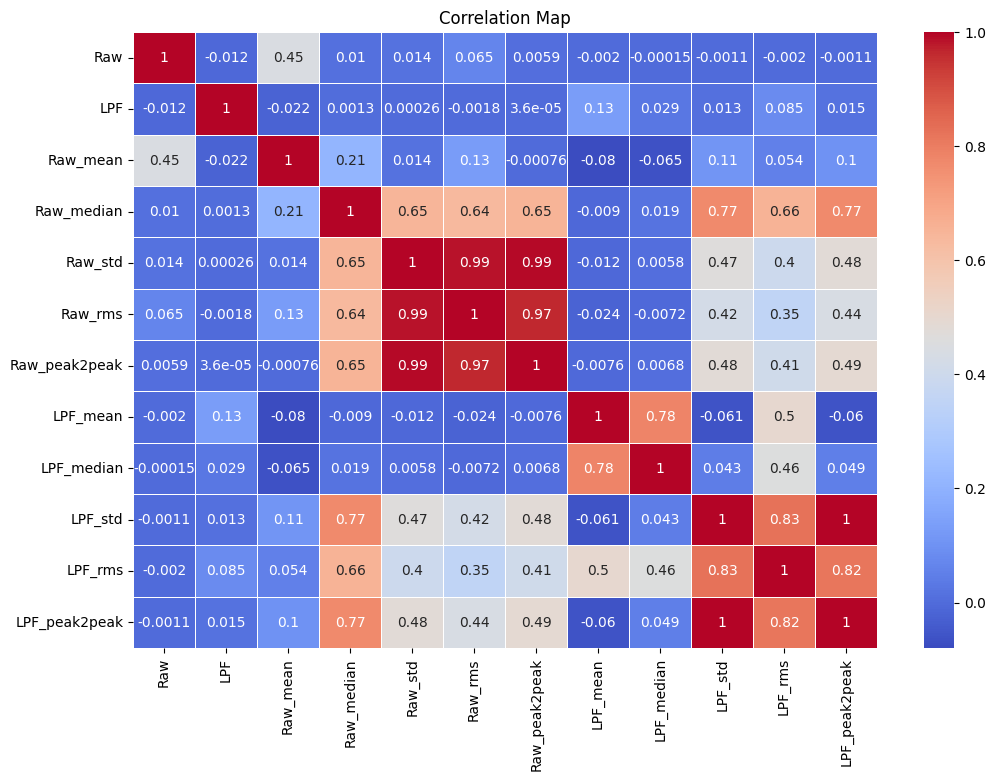

In [ ]:
perform_eda(healthy_data_with_features)

Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16161 entries, 0 to 16160
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Raw            16161 non-null  int64  
 1   LPF            16161 non-null  float64
 2   Raw_mean       16157 non-null  float64
 3   Raw_median     16157 non-null  float64
 4   Raw_std        16157 non-null  float64
 5   Raw_rms        16157 non-null  float64
 6   Raw_peak2peak  16157 non-null  float64
 7   LPF_mean       16157 non-null  float64
 8   LPF_median     16157 non-null  float64
 9   LPF_std        16157 non-null  float64
 10  LPF_rms        16157 non-null  float64
 11  LPF_peak2peak  16157 non-null  float64
dtypes: float64(11), int64(1)
memory usage: 1.5 MB
None

Data head:
    Raw          LPF     Raw_mean  Raw_median    Raw_std      Raw_rms  \
0  2030  2042.843147  2031.800000      2030.0   5.585696  2031.806142   
1  2041  2042.843147  2032.000000      2031

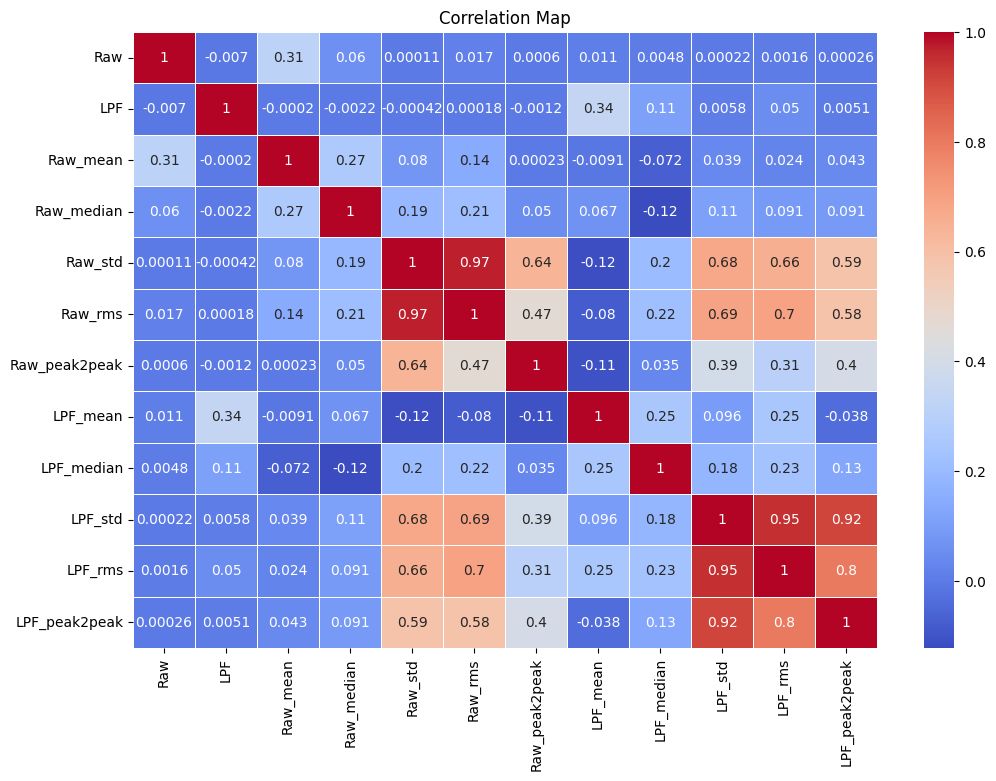

In [ ]:
perform_eda(fast_data_with_features)

Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18394 entries, 0 to 18393
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Raw            18394 non-null  int64  
 1   LPF            18394 non-null  float64
 2   Raw_mean       18390 non-null  float64
 3   Raw_median     18390 non-null  float64
 4   Raw_std        18390 non-null  float64
 5   Raw_rms        18390 non-null  float64
 6   Raw_peak2peak  18390 non-null  float64
 7   LPF_mean       18390 non-null  float64
 8   LPF_median     18390 non-null  float64
 9   LPF_std        18390 non-null  float64
 10  LPF_rms        18390 non-null  float64
 11  LPF_peak2peak  18390 non-null  float64
dtypes: float64(11), int64(1)
memory usage: 1.7 MB
None

Data head:
    Raw      LPF     Raw_mean  Raw_median    Raw_std      Raw_rms  \
0  2048  2063.15  2043.000000      2048.0  10.099505  2043.019971   
1  2048  2060.30  2042.666667      2047.0   9.07009

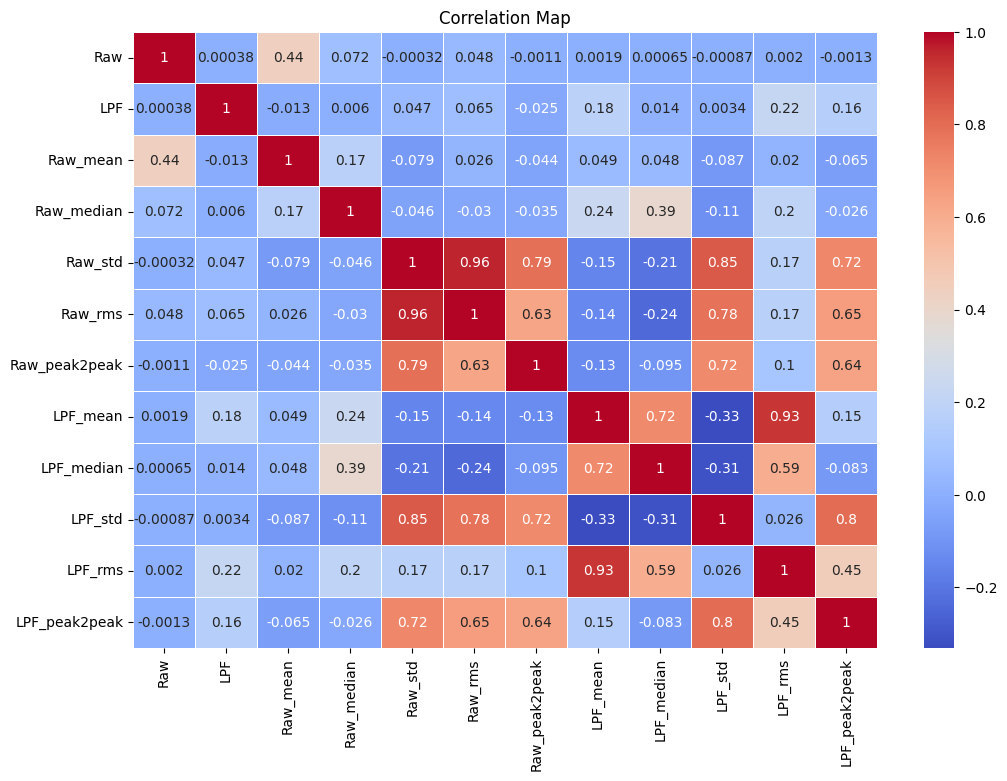

In [ ]:
perform_eda(small_data_with_features)

In [ ]:
healthy_data_with_features_cleaned = healthy_data_with_features.dropna()

In [ ]:
for i in healthy_data_with_features.columns:
    print(i)
    print(healthy_data_with_features[i].nunique())
    print(healthy_data_with_features[i].unique())

Raw
318
[2046 2048 2055 2050 2047 2038 2044 2039 2040 2043 2042 2034 2032 2059
 2045 2037 2029 2049 2056 2035 2057 2036 2053 2060 2051 2041 2052 2031
 2054 2033 2061 2064 2027 2028 2030 2058 2025 2067 2063 2023 2062 2021
 2026 2069 2065 2066 2022 2072 2012 2014 2016 2088 2082 2083 2013 2017
 2086 2077 2024 2070 2008 2000 1996 2079 2101 2097 2107 2099 2094 2098
 2091 1997 2010 2020 2009 2005 1982 1991 2073 2071 2080 2074 2081 2087
 2105 2102 2075 2076 2085 2019 1892 1673 1370 1122 1038 1204 1681 2555
 3375 3599 3275 2650 2104 1652 1318 1033  765  381    0  582 3500 4074
 4030 4075 4050 4071 4031 3866 3357 2724 2142 1565 1058  656  322   60
    8  441 1372 2432 3311 3864 4018 3967 3682 3232 2763 2239 1755 1328
  994  709  518  565 1018 1745 2435 2942 3223 3288 3149 2905 2575 2235
 1888 1568 1298 1119 1092 1359 1788 2224 2528 2698 2687 2577 2388 2157
 1948 1769 1641 1670 1822 2202 2271 2264 2182 2018 2093 2178 2244 2270
 2269 2263 2227 2183 2110 1928 2096 2068 2004 2090 2084 1960 1938 195

In [ ]:



fast_data_with_features_cleaned = fast_data_with_features.dropna()


In [ ]:
for i in fast_data_with_features.columns:
    print(i)
    print(fast_data_with_features[i].nunique())
    print(fast_data_with_features[i].unique())

Raw
3234
[2030 2041 2026 ... 2481 3833 3998]
LPF
14116
[2042.84314667 2006.26       2009.27       ... 2056.78       2046.33
 2028.21      ]
Raw_mean
8192
[2031.8        2032.         2034.85714286 ... 2046.744      2042.954
           nan]
Raw_median
258
[2030.  2031.  2032.  2032.5 2033.  2037.  2041.  2043.  2045.  2047.5
 2050.  2041.5 2042.  2043.5 2040.  2039.  2035.  2034.  2051.  2052.
 2053.  2054.  2044.5 2044.  2057.  2060.  2061.  2062.  2062.5 2063.
 2063.5 2064.  2065.5 2067.  2065.  2067.5 2075.5 2086.  2090.5 2087.5
 2093.5 2094.  2096.5 2097.5 2098.5 2103.5 2107.5 2103.  2111.5 2117.
 2090.  2120.  2113.5 2085.5 2075.  2066.  2052.5 2042.5 2074.  2018.5
 2012.  2009.  2069.5 2081.  2029.  2107.  2112.  2118.  2104.5 2095.
 2017.  1988.  1986.  1980.5 2092.  2099.  1990.  2025.5 1972.5 1999.
 1962.  1970.5 1973.  1990.5 1999.5 2008.  2023.5 2056.5 2085.  2096.
 2083.  2098.  2101.  2106.5 2007.  1998.5 1982.  1977.5 1984.  2024.5
 2045.5 2010.  2049.5 2011.  2014.5 2028.

In [ ]:
small_data_with_features_cleaned = small_data_with_features.dropna()

In [ ]:
for i in small_data_with_features.columns:
    print(i)
    print(small_data_with_features[i].nunique())
    print(small_data_with_features[i].unique())

Raw
3593
[2048 2046 2025 ...  427  537 3501]
LPF
17706
[2063.15       2060.3        2053.84       ... 2007.06005859 2001.58996582
 2002.        ]
Raw_mean
12339
[2043.         2042.66666667 2045.28571429 ... 2038.844      2038.258
           nan]
Raw_median
480
[2048.  2047.  2046.  2045.5 2045.  2047.5 2046.5 2044.5 2044.  2043.5
 2043.  2042.5 2042.  2041.5 2041.  2040.5 2040.  2039.5 2039.  2038.5
 2038.  2037.  2036.  2035.5 2035.  2034.5 2034.  2033.5 2033.  2032.5
 2032.  2031.5 2031.  2030.5 2030.  2029.5 2028.5 2028.  2027.5 2027.
 2026.  2025.  2024.  2023.  2022.5 2021.5 2021.  2020.  2019.  2018.5
 2017.5 2016.5 2023.5 2024.5 2022.  2016.  2013.5 2009.5 2008.  2007.
 2004.5 2003.  2001.5 1999.5 1997.5 2001.  1993.  1985.5 1981.  1976.5
 1971.5 1967.5 1966.  1963.5 1961.  1955.  1964.5 1991.5 2002.5 1988.5
 1994.5 2010.  2014.  2048.5 2049.  2050.  2051.  2051.5 2052.5 2053.5
 2054.5 2055.  2055.5 2057.5 2059.  2059.5 2060.  2062.5 2065.  2052.
 2003.5 1999.  1992.5 1995.5 19

giving labels to the data

In [ ]:
healthy_data_with_features_cleaned['label'] = 0
fast_data_with_features_cleaned['label'] = 1
small_data_with_features_cleaned['label'] = 2

<ipython-input-27-1e0d06bd6895>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  healthy_data_with_features_cleaned['label'] = 0
<ipython-input-27-1e0d06bd6895>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fast_data_with_features_cleaned['label'] = 1
<ipython-input-27-1e0d06bd6895>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

concatenating the train data

In [ ]:
train_data = pd.concat([healthy_data_with_features_cleaned,
                      fast_data_with_features_cleaned,
                      small_data_with_features_cleaned],
                     ignore_index=True)

In [ ]:
train_data.head()

,Raw,LPF,Raw_mean,Raw_median,Raw_std,Raw_rms,Raw_peak2peak,LPF_mean,LPF_median,LPF_std,LPF_rms,LPF_peak2peak,label
0,2046,2042.161624,2049.200000,2048.0,3.563706,2049.202479,9.0,2042.161624,2042.161624,0.0,2042.161624,0.0,0
1,2048,2042.161624,2049.333333,2049.0,3.204164,2049.335421,9.0,2042.161624,2042.161624,0.0,2042.161624,0.0,0
2,2055,2042.161624,2047.714286,2048.0,5.186980,2047.719917,17.0,2042.161624,2042.161624,0.0,2042.161624,0.0,0
3,2050,2042.161624,2047.250000,2047.5,4.978525,2047.255297,17.0,2042.161624,2042.161624,0.0,2042.161624,0.0,0
4,2047,2042.161624,2046.333333,2047.0,5.408327,2046.339686,17.0,2042.161624,2042.161624,0.0,2042.161624,0.0,0


Loading test data

In [ ]:
h_t1 = add_labels(pd.read_excel('/content/drive/MyDrive/stable small movement/TestScans/NMTestScan1.xlsx'), 'healthy')
h_t2 = add_labels(pd.read_excel('/content/drive/MyDrive/stable small movement/TestScans/NMTestScan2.xlsx'), 'healthy')

In [ ]:
i_t1 = add_labels(pd.read_excel('/content/drive/MyDrive/stable small movement/TestScans/FFTestScan1.xlsx'), 'fast_movement')
i_t2 = add_labels(pd.read_excel('/content/drive/MyDrive/stable small movement/TestScans/FFTestScan2.xlsx'), 'fast_movement')
i_t3 = add_labels(pd.read_excel('/content/drive/MyDrive/stable small movement/TestScans/SMTestscan1.xlsx'), 'small_movement')
i_t4 = add_labels(pd.read_excel('/content/drive/MyDrive/stable small movement/TestScans/SMTestScan2.xlsx'), 'small_movement')

Concatenating the test data

In [ ]:
h_t = pd.concat([h_t1, h_t2])
f_t= pd.concat([i_t1, i_t2])
s_t= pd.concat([i_t3, i_t4])

In [ ]:
h_t = preprocess_data(h_t)
f_t = preprocess_data(f_t)
s_t = preprocess_data(s_t)

In [ ]:
numeric_columns4 = h_t.select_dtypes(include=np.number).columns
numeric_columns5 = f_t.select_dtypes(include=np.number).columns
numeric_columns6 = s_t.select_dtypes(include=np.number).columns

Extracting the features from tets data

In [ ]:
h_t_aggregated_features = extractor.fit_transform(h_t[numeric_columns4])
f_t_aggregated_features = extractor.fit_transform(f_t[numeric_columns5])
s_t_aggregated_features = extractor.fit_transform(s_t[numeric_columns6])


In [ ]:
h_t_reset = h_t.reset_index(drop=True)
f_t_reset = f_t.reset_index(drop=True)
s_t_reset = s_t.reset_index(drop=True)

In [ ]:
h_t_aggregated_features_reset = h_t_aggregated_features.reset_index(drop=True)
f_t_aggregated_features_reset = f_t_aggregated_features.reset_index(drop=True)
s_t_aggregated_features_reset = s_t_aggregated_features.reset_index(drop=True)

In [ ]:
h_t_with_features = pd.concat([h_t_reset, h_t_aggregated_features_reset], axis=1)
f_t_with_features = pd.concat([f_t_reset, f_t_aggregated_features_reset], axis=1)
s_t_with_features = pd.concat([s_t_reset, s_t_aggregated_features_reset], axis=1)

performing EDA on test data

Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7230 entries, 0 to 7229
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Raw            7230 non-null   int64  
 1   LPF            7230 non-null   float64
 2   Raw_mean       7226 non-null   float64
 3   Raw_median     7226 non-null   float64
 4   Raw_std        7226 non-null   float64
 5   Raw_rms        7226 non-null   float64
 6   Raw_peak2peak  7226 non-null   float64
 7   LPF_mean       7226 non-null   float64
 8   LPF_median     7226 non-null   float64
 9   LPF_std        7226 non-null   float64
 10  LPF_rms        7226 non-null   float64
 11  LPF_peak2peak  7226 non-null   float64
dtypes: float64(11), int64(1)
memory usage: 677.9 KB
None

Data head:
    Raw         LPF     Raw_mean  Raw_median     Raw_std      Raw_rms  \
0  2767  2129.52124  2563.800000      2556.0  148.743739  2567.249540   
1  2644  2129.52124  2527.000000      2509.

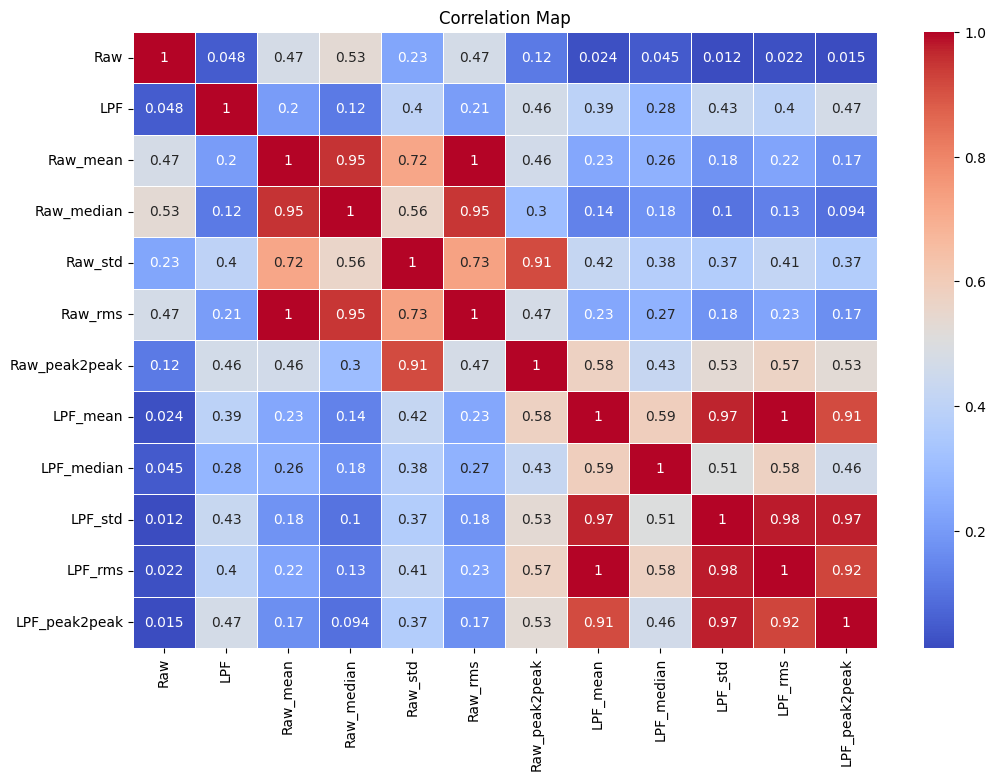

In [ ]:
perform_eda(h_t_with_features)

Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7361 entries, 0 to 7360
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Raw            7361 non-null   int64  
 1   LPF            7361 non-null   float64
 2   Raw_mean       7357 non-null   float64
 3   Raw_median     7357 non-null   float64
 4   Raw_std        7357 non-null   float64
 5   Raw_rms        7357 non-null   float64
 6   Raw_peak2peak  7357 non-null   float64
 7   LPF_mean       7357 non-null   float64
 8   LPF_median     7357 non-null   float64
 9   LPF_std        7357 non-null   float64
 10  LPF_rms        7357 non-null   float64
 11  LPF_peak2peak  7357 non-null   float64
dtypes: float64(11), int64(1)
memory usage: 690.2 KB
None

Data head:
    Raw          LPF     Raw_mean  Raw_median     Raw_std      Raw_rms  \
0  1999  2146.503174  1981.600000      1987.0  116.225212  1984.324873   
1  2162  2146.503174  1987.833333      19

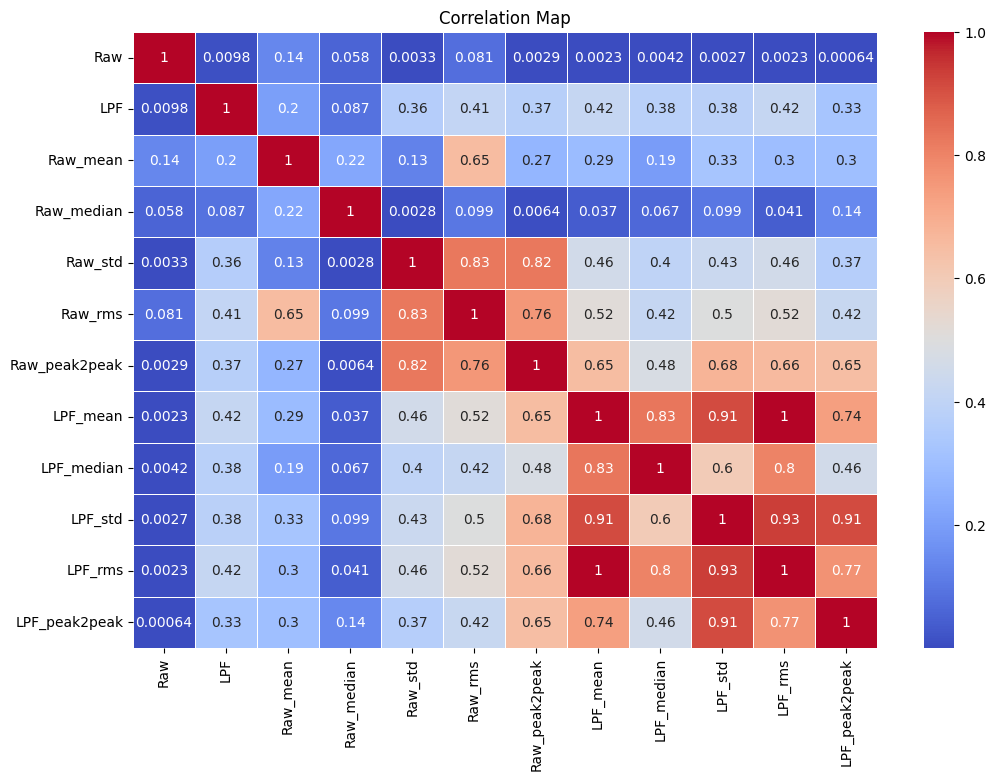

In [ ]:
perform_eda(f_t_with_features)

Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7601 entries, 0 to 7600
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Raw            7601 non-null   int64  
 1   LPF            7601 non-null   float64
 2   Raw_mean       7597 non-null   float64
 3   Raw_median     7597 non-null   float64
 4   Raw_std        7597 non-null   float64
 5   Raw_rms        7597 non-null   float64
 6   Raw_peak2peak  7597 non-null   float64
 7   LPF_mean       7597 non-null   float64
 8   LPF_median     7597 non-null   float64
 9   LPF_std        7597 non-null   float64
 10  LPF_rms        7597 non-null   float64
 11  LPF_peak2peak  7597 non-null   float64
dtypes: float64(11), int64(1)
memory usage: 712.7 KB
None

Data head:
    Raw          LPF     Raw_mean  Raw_median    Raw_std      Raw_rms  \
0  4068  2125.338379  4065.600000      4069.0  15.598077  4065.623937   
1  4069  2125.338379  4066.500000      4070

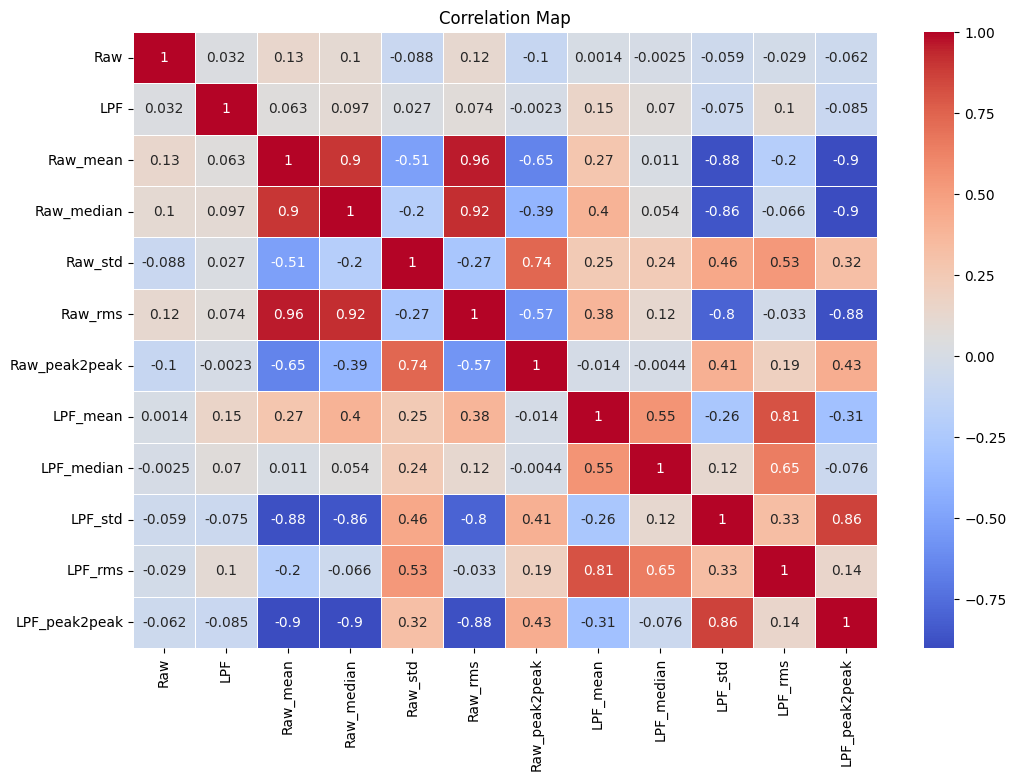

In [ ]:
perform_eda(s_t_with_features)

In [ ]:
h_t_with_features_cleaned = h_t_with_features.dropna()

In [ ]:
for i in h_t_with_features.columns:
    print(i)
    print(h_t_with_features[i].nunique())
    print(h_t_with_features[i].unique())

Raw
245
[2767 2644 2556 2463 2389 2343 2295 2253 2240 2223 2209 2189 2175 2158
 2154 2125 2115 2112 2108 2104 2103 2093 2100 2082 2085 2090 2088 2087
 2101 2086 2089 2083 2081 2073 2078 2084 2071 2068 2059 2075 2069 2079
 2065 2080 2077 2063 2072 2050 2042 2052 2049 2070 2076 2096 2048 2045
 2036 2058 2060 2057 2051 2064 2067 2066 2056 2053 2054 2062 2047 2055
 2046 2035 2074 2040 2041 2044 2043 2039 2037 2027 2033 2061 2038 2019
 2032 2025 2021 2028 2034 2030 2026 2020 2029 2031 2024 2023 2016 2022
 2010 2011 2018 2095 2013 1999 2017 2012 2003 2132 2172 2208 2216 2162
 2113 2014 1969 1951 1953 1944 1950 1960 1972 2008 1995 2002 2007 2015
 1975 1958 1943 1948 1956 1982 1978 1976 1952 1962 1967 1970 1993 2004
 2005 1997 2110 2124 2135 2143 2145 2136 2131 2122 2097 2434 2373 2322
 2281 2226 2211 2191 2194 2180 2160 2149 2119 2120 2129 2111 2116 2099
 2098 2094 2105 2091 2102 2106 2107 2092 2121 2144 2156 2140 1961 1968
 1963 1994 1955 1949 1964 1984 2161 2168 2166 2148 2123 2109 2006 198

In [ ]:
f_t_with_features_cleaned = f_t_with_features.dropna()


In [ ]:
for i in f_t_with_features.columns:
    print(i)
    print(f_t_with_features[i].nunique())
    print(f_t_with_features[i].unique())

Raw
1593
[1999 2162 1987 ... 1368  988  955]
LPF
6914
[2146.50317383 1850.75       2545.63989258 ... 2113.08007812 1970.43994141
 1924.48999023]
Raw_mean
4550
[1981.6        1987.83333333 1846.57142857 ... 2047.79       2045.08
           nan]
Raw_median
156
[1987.  1993.  1941.5 1896.  1999.  2009.  2019.  2090.5 2062.5 2106.
 2134.  1974.5 1962.  1930.  1905.  1933.5 1940.5 1919.  1912.  1952.
 2007.5 2016.  2006.  2013.  2014.5 2017.5 2022.  2025.  2032.5 2040.
 2040.5 2041.  2048.  2055.  2031.  2035.5 2055.5 2056.  2059.  2062.
 2066.  2070.  2070.5 2071.  2072.  2051.5 2057.  2058.  2060.  2044.5
 2046.  2044.  2043.  2042.  2041.5 2037.5 2056.5 2048.5 2052.  2053.5
 2057.5 2050.5 2043.5 2042.5 2046.5 2049.5 2051.  2050.  2061.  2061.5
 2063.  2064.  2058.5 2052.5 2049.  2047.  2045.  2039.  2038.5 2038.
 2037.  2036.5 2034.5 2033.5 2033.  2030.  2029.5 2025.5 2023.  2021.5
 2020.5 2018.  2021.  2024.5 2027.5 2030.5 2015.5 2014.  2011.5 2010.5
 2039.5 2054.  2054.5 2047.5 2053.  

In [ ]:
s_t_with_features_cleaned = s_t_with_features.dropna()

In [ ]:
for i in s_t_with_features.columns:
    print(i)
    print(s_t_with_features[i].nunique())
    print(s_t_with_features[i].unique())

Raw
2766
[4068 4069 4072 ... 2324 2408 2475]
LPF
7251
[2125.33837891 1800.33996582 2489.5        ... 1275.26000977  756.2800293
  264.01000977]
Raw_mean
6915
[4065.6        4066.5        4068.42857143 ... 2038.242      2037.124
           nan]
Raw_median
657
[4069.  4070.  4071.  4071.5 4072.  4072.5 4068.5 4068.  4066.5 4065.
 4064.  4063.  4062.  4061.  4059.5 4058.  4056.  4054.  4052.5 4051.
 4049.  4047.  4046.5 4046.  4044.5 4043.  4042.  4041.  4040.  4039.
 4038.5 4038.  4036.5 4035.  4039.5 4034.  4033.  4032.  4031.  4030.5
 4030.  4010.  3990.  3976.5 3963.  3939.5 3916.  3866.5 3817.  3788.
 3759.  3755.5 3752.  3691.5 3913.5 3911.  3864.  3631.  3505.  3379.
 3360.  3341.  3335.5 3330.  3306.  3282.  3272.5 3263.  3496.5 3614.
 3622.5 3534.  3454.  3416.5 3206.  3149.  3141.5 3316.5 3303.  3292.5
 3259.5 3256.  3241.5 3227.  3188.  3142.  3135.  3134.5 3134.  3248.
 3240.  3233.5 3122.  3110.  3104.5 3099.  3098.  3097.  3095.5 3094.
 3089.  3084.  3055.  3026.  3012.  299

In [ ]:
h_t_with_features_cleaned['label'] = 0
f_t_with_features_cleaned['label'] = 1
s_t_with_features_cleaned['label'] = 2

<ipython-input-48-011a9ce89860>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h_t_with_features_cleaned['label'] = 0
<ipython-input-48-011a9ce89860>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f_t_with_features_cleaned['label'] = 1
<ipython-input-48-011a9ce89860>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

In [ ]:
test_data = pd.concat([h_t_with_features_cleaned,
                      f_t_with_features_cleaned,
                      s_t_with_features_cleaned],
                     ignore_index=True)

In [ ]:
test_data.head()

,Raw,LPF,Raw_mean,Raw_median,Raw_std,Raw_rms,Raw_peak2peak,LPF_mean,LPF_median,LPF_std,LPF_rms,LPF_peak2peak,label
0,2767,2129.52124,2563.800000,2556.0,148.743739,2567.249540,378.0,2129.52124,2129.52124,0.0,2129.52124,0.0,0
1,2644,2129.52124,2527.000000,2509.5,160.702209,2531.254630,424.0,2129.52124,2129.52124,0.0,2129.52124,0.0,0
2,2556,2129.52124,2493.857143,2463.0,170.909751,2498.871888,472.0,2129.52124,2129.52124,0.0,2129.52124,0.0,0
3,2463,2129.52124,2463.750000,2426.0,179.690806,2469.477020,514.0,2129.52124,2129.52124,0.0,2129.52124,0.0,0
4,2389,2129.52124,2438.888889,2389.0,183.889535,2445.043376,527.0,2129.52124,2129.52124,0.0,2129.52124,0.0,0


In [ ]:
test_data.columns

Index(['Raw', 'LPF', 'Raw_mean', 'Raw_median', 'Raw_std', 'Raw_rms',
       'Raw_peak2peak', 'LPF_mean', 'LPF_median', 'LPF_std', 'LPF_rms',
       'LPF_peak2peak', 'label'],
      dtype='object')

In [ ]:
train_data.shape

(50456, 13)

In [ ]:
test_data.shape

(22180, 13)

defining selected features

In [ ]:
selected_features = [ 'Raw_peak2peak', 'LPF_std', 'LPF_peak2peak', 'Raw_std', 'LPF_rms']

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

defining x_train,x_test,y_train,y_test

In [ ]:
X_train = train_data[selected_features]
y_train = train_data['label']
X_test = test_data[selected_features]
y_test = test_data['label']

 this code is an essential step in handling imbalanced datasets for machine learning tasks. It ensures that the model is not biased toward the majority class by creating synthetic examples for the minority class, thereby improving the model's ability to generalize to minority class instances.

In [ ]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

StandardScaler(): This is the transformation to be applied to the selected numerical features. StandardScaler standardizes features by removing the mean and scaling to unit variance.

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), selected_features)
    ])

Build & Compile the model

In [ ]:
model = keras.Sequential([
    Dense(64, activation='relu', input_shape=(len(selected_features),)),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')  # 3 classes, so use softmax activation
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                384       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 2563 (10.01 KB)
Trainable params: 2563 (10.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
pip install --upgrade tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.1 MB/s eta 0:00:00
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0


In [ ]:
for layer in model.layers:
    print(layer.get_config(), layer.input_shape, layer.output_shape)


{'name': 'dense', 'trainable': True, 'dtype': 'float32', 'batch_input_shape': (None, 5), 'units': 64, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None} (None, 5) (None, 64)
{'name': 'dense_1', 'trainable': True, 'dtype': 'float32', 'units': 32, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': Non

In [ ]:
model.summary(print_fn=print)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                384       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 2563 (10.01 KB)
Trainable params: 2563 (10.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=10)
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Epoch 1/10
1577/1577 [==============================] - 3s 2ms/step - loss: 3.5132 - accuracy: 0.8709
Epoch 2/10
1577/1577 [==============================] - 4s 3ms/step - loss: 1.8006 - accuracy: 0.8878
Epoch 3/10
1577/1577 [==============================] - 4s 2ms/step - loss: 1.3470 - accuracy: 0.8972
Epoch 4/10
1577/1577 [==============================] - 3s 2ms/step - loss: 1.0096 - accuracy: 0.9025
Epoch 5/10
1577/1577 [==============================] - 6s 4ms/step - loss: 0.8325 - accuracy: 0.9075
Epoch 6/10
1577/1577 [==============================] - 8s 5ms/step - loss: 0.6142 - accuracy: 0.9117
Epoch 7/10
1577/1577 [==============================] - 5s 3ms/step - loss: 0.4868 - accuracy: 0.9183
Epoch 8/10
1577/1577 [==============================] - 8s 5ms/step - loss: 0.4489 - accuracy: 0.9190
Epoch 9/10
1577/1577 [==============================] - 6s 4ms/step - loss: 0.3444 - accuracy: 0.9253
Epoch 10/10
694/694 [==============================] - 2s 2ms/step - loss: 5.9964 

In [ ]:
KERAS_MODEL_NAME = "model.h5"
model.save(KERAS_MODEL_NAME)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy is {}%'.format(round(100*test_acc, 2)))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


694/694 - 1s - loss: 5.9964 - accuracy: 0.8368 - 752ms/epoch - 1ms/step

Test accuracy is 83.68%


TF Lite Model

In [ ]:
TF_LITE_MODEL_FILE_NAME = "tf_lite_model.tflite"

In [ ]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert()

In [ ]:
tflite_model_name = TF_LITE_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

12344

Check Input Tensor Shape

In [ ]:
interpreter = tf.lite.Interpreter(model_path = TF_LITE_MODEL_FILE_NAME)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [1 5]
Input Type: <class 'numpy.float32'>
Output Shape: [1 3]
Output Type: <class 'numpy.float32'>


In [ ]:
num_rows = test_data.shape[0]  # Get the number of rows from test_data
num_input_columns = 5
num_output_columns = 3

# Resize input tensor
input_tensor_shape = (num_rows, num_input_columns)
interpreter.resize_tensor_input(input_details[0]['index'], input_tensor_shape)

# Resize output tensor
output_tensor_shape = (num_rows, num_output_columns)
interpreter.resize_tensor_input(output_details[0]['index'], output_tensor_shape)


Resize Tensor Shape

In [ ]:
interpreter.resize_tensor_input(input_details[0]['index'], (22180, 5))
interpreter.resize_tensor_input(output_details[0]['index'], (22180, 3))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [22180     5]
Input Type: <class 'numpy.float32'>
Output Shape: [22180     3]
Output Type: <class 'numpy.float32'>


In [ ]:
X_test.dtypes

Raw_peak2peak    float64
LPF_std          float64
LPF_peak2peak    float64
Raw_std          float64
LPF_rms          float64
dtype: object

In [ ]:
X_test_numpy = np.array(X_test, dtype=np.float32)


In [ ]:
X_test.dtypes

Raw_peak2peak    float64
LPF_std          float64
LPF_peak2peak    float64
Raw_std          float64
LPF_rms          float64
dtype: object

In [ ]:
X_test_numpy = np.array(X_test, dtype=np.float32)
X_test = pd.DataFrame(X_test_numpy, columns=X_test.columns)


In [ ]:
X_test.dtypes

Raw_peak2peak    float32
LPF_std          float32
LPF_peak2peak    float32
Raw_std          float32
LPF_rms          float32
dtype: object

Setting the Input Tensor: interpreter.set_tensor(input_details[0]['index'], X_test)

interpreter: This is an instance of the TensorFlow Lite interpreter.
input_details[0]['index']: It refers to the index of the input tensor in the interpreter.
X_test: This is the input data (features) that you want to use for making predictions.
The code sets the input tensor of the TFLite model to the provided X_test data.
Invoking the Model: interpreter.invoke()

invoke(): This method is called to perform the inference using the provided input tensor. It triggers the execution of the TFLite model.
Getting the Output Tensor: tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])

output_details[0]['index']: It refers to the index of the output tensor in the interpreter.
get_tensor(): This method retrieves the output tensor containing the predictions made by the TFLite model.
Printing Prediction Results Shape: print("Prediction results shape:", tflite_model_predictions.shape)

This line prints the shape of the tensor containing the model predictions. It helps you understand the dimensions of the output tensor.
Extracting Prediction Classes: prediction_classes = np.argmax(tflite_model_predictions, axis=1)

np.argmax(tflite_model_predictions, axis=1): This operation extracts the predicted class indices from the output tensor. It finds the index with the highest value along axis 1, assuming each row corresponds to predictions for different classes.

In [ ]:
interpreter.set_tensor(input_details[0]['index'], X_test)
interpreter.invoke()
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
print("Prediction results shape:", tflite_model_predictions.shape)
prediction_classes = np.argmax(tflite_model_predictions, axis=1)

Prediction results shape: (22180, 3)


In [ ]:
print(prediction_classes)

[1 1 1 ... 2 2 2]


In [ ]:
acc = accuracy_score(prediction_classes, y_test)

In [ ]:
print('Test accuracy TFLITE model is {}%'.format(round(100*acc, 2)))

Test accuracy TFLITE model is 83.68%
